In [2]:
%run 'Setup.py'

8 different classes: Electronic, Experimental, Folk, Hip-Hop, Instrumental, International, Pop or Rock.
objective 1: construct a classifier which, based on the features of a song, predicts its genre
objective 2: estimate its generalisation error under the 0–1 loss.
Features are real-valued, correspond to summary statistics (mean, sd, skewness, kurtosis, median, min, max) of 
time series of various music features, such as the chromagram or the Mel-frequency cepstrum.
Feature description: 

Feature description: 
chroma_cens: Chroma Energy Normalized (CENS, 12 chroma) - 84 features
chroma_cqt: Constant-Q chromagram (12 chroma) - 84 features
chroma_stft: Chromagram (12 chroma) - 84 features
mfcc: Mel-frequency cepstrum (20 coefficients) - 140 features
rmse: Root-mean-square - 7 features
spectral_bandwidth: Spectral bandwidth - 7 features
spectral_centroid: Spectral centroid - 7 features
spectral_contrast: Spectral contrast (7 frequency bands) - 49 features
spectral_rolloff: Roll-off freque

In [3]:
# Prepare data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_np.ravel()) #

# Split training data into training and temporary validation sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x_train, y_train_encoded, test_size=0.4, random_state=42)

# Split the temporary validation set into validation and fake test set
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  
X_real_test_scaled = scaler.transform(x_test) # real test set we don't have labels for

In [4]:
def split_features_by_type(X, feature_structure):
    """
    Splits the dataset into subsets based on the feature structure provided.

    :param X: numpy array, the dataset to be split (features only)
    :param feature_structure: dict, keys are feature names and values are the number of features of that type
    :return: dict of feature subsets
    """
    feature_subsets = {}
    start_idx = 0
    
    for feature_name, feature_count in feature_structure.items():
        end_idx = start_idx + feature_count
        feature_subsets[feature_name] = X[:, start_idx:end_idx]
        start_idx = end_idx
    
    return feature_subsets

# Define the feature structure
feature_structure = {
    'chroma_cens': 84,
    'chroma_cqt': 84,
    'chroma_stft': 84,
    'mfcc': 140,
    'rmse': 7,
    'spectral_bandwidth': 7,
    'spectral_centroid': 7,
    'spectral_contrast': 49,
    'spectral_rolloff': 7,
    'tonnetz': 42,
    'zcr': 7
}

# Explore other feature structures based on correlation

In [11]:
import seaborn as sns

X_trained_scaled_df = pd.DataFrame(X_train_scaled, columns=x_train.columns)

# # Compute the correlation matrix
# corr_matrix = X_trained_scaled_df.corr()

# # Plot the correlation matrix as a heatmap
# sns.heatmap(corr_matrix, annot=True, cmap='seismic')

It is actually quite hard to tease out any structure, except for a few very locally correlated features that we can think about eliminating. Alternatively, will just try to use the feature clusters.

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


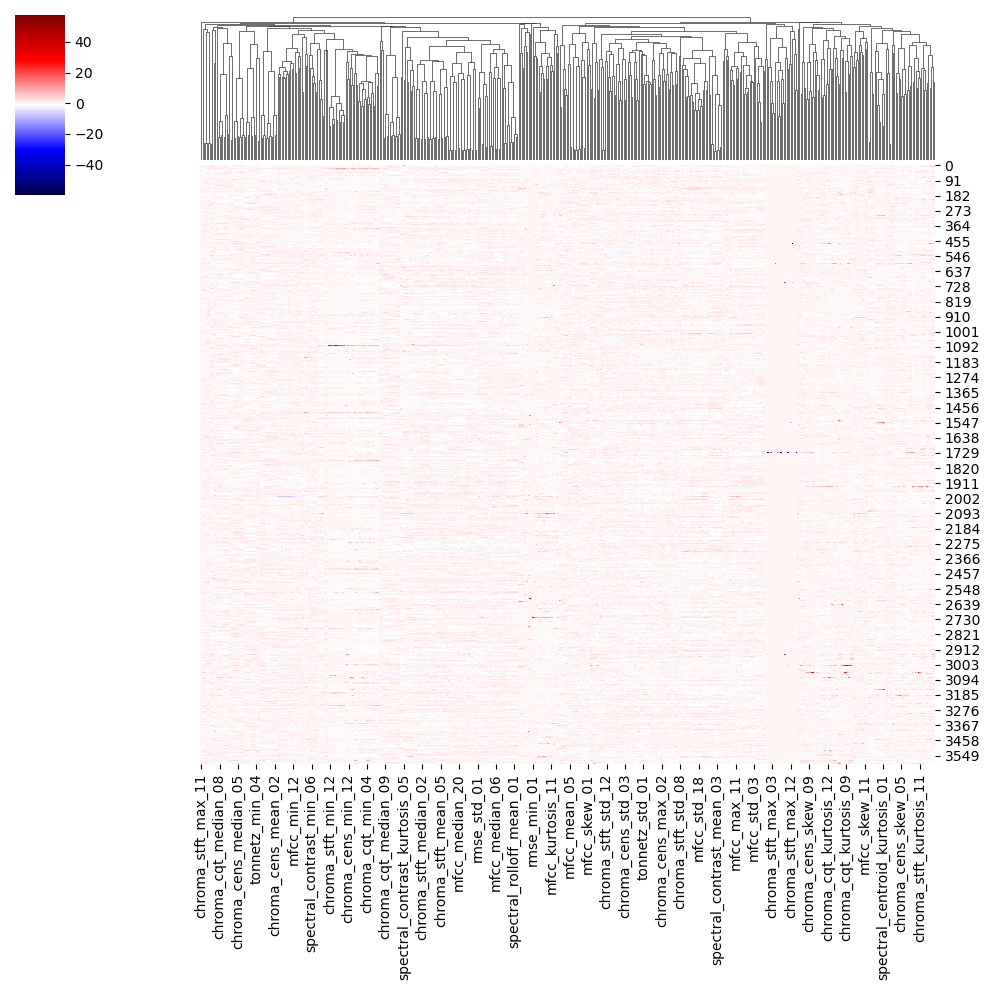

In [12]:
cg = sns.clustermap(X_trained_scaled_df, row_cluster=False, col_cluster=True, cmap= 'seismic')
# cg

import scipy

# Get dendrogram cluster labels
dendrogram_label_10_clust = scipy.cluster.hierarchy.fcluster(cg.dendrogram_col.linkage, t=10, criterion='maxclust')
dendrogram_label_6_clust = scipy.cluster.hierarchy.fcluster(cg.dendrogram_col.linkage, t=6, criterion='maxclust')


# Boosting separately on feature subsets

In [3]:
# Get Frensi's white list
df = pd.read_csv('X_train_reduced.csv')
whitelist = list(df.columns)

# # Print the whitelist
# print(whitelist)


['chroma_cens_kurtosis_01', 'chroma_cens_kurtosis_02', 'chroma_cens_kurtosis_03', 'chroma_cens_kurtosis_04', 'chroma_cens_kurtosis_05', 'chroma_cens_kurtosis_06', 'chroma_cens_kurtosis_07', 'chroma_cens_kurtosis_08', 'chroma_cens_kurtosis_09', 'chroma_cens_kurtosis_10', 'chroma_cens_kurtosis_11', 'chroma_cens_kurtosis_12', 'chroma_cens_max_01', 'chroma_cens_max_02', 'chroma_cens_max_03', 'chroma_cens_max_04', 'chroma_cens_max_05', 'chroma_cens_max_06', 'chroma_cens_max_07', 'chroma_cens_max_08', 'chroma_cens_max_09', 'chroma_cens_max_10', 'chroma_cens_max_11', 'chroma_cens_max_12', 'chroma_cens_mean_01', 'chroma_cens_mean_02', 'chroma_cens_mean_03', 'chroma_cens_mean_04', 'chroma_cens_mean_05', 'chroma_cens_mean_06', 'chroma_cens_median_01', 'chroma_cens_median_02', 'chroma_cens_median_03', 'chroma_cens_median_04', 'chroma_cens_median_05', 'chroma_cens_median_06', 'chroma_cens_median_07', 'chroma_cens_median_08', 'chroma_cens_median_09', 'chroma_cens_median_10', 'chroma_cens_median_11'

In [44]:
# Check if Frensi accidentally removed important features
element = 'spectral_contrast_median_04'

element in whitelist

# Max's most important feature is not in the whitelist, so will not use the reduced csv for onw

False

In [9]:
def split_features_by_clusters(X_train_scaled, cluster_labels): #, whitelist = whitelist):
    """
    Splits the dataset into subsets based on the cluster labels provided.

    :param data_df: pandas DataFrame, the dataset to be split (features only)
    :param cluster_labels: numpy array, the cluster labels for each feature
    :param whitelist: list, the features to be included in the subsets
    :return: dict of feature subsets
    """
    X_trained_scaled_df = pd.DataFrame(X_train_scaled, columns=x_train.columns)

    feature_subsets = {}
    for label in np.unique(cluster_labels):
        cluster_df = X_trained_scaled_df.iloc[:,np.where(dendrogram_label_6_clust==1)[0]]
        # cluster_df = cluster_df.loc[:,cluster_df.columns.isin(whitelist)]
        feature_subsets[f"Cluster {str(label)}"] = cluster_df.values
    return feature_subsets

Load Data and Convert to DMatrix

## Evaluate model performances based on different feature subsets

Maybe first experiment with which models work the best on each feature subset?

### Based on the name of the features

In [6]:
# Try the original data split
train_subsets = split_features_by_type(X_train_scaled, feature_structure)


/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.287 (0.022)
>knn 0.245 (0.026)
>cart 0.189 (0.018)
>svm 0.319 (0.021)
>bayes 0.218 (0.014)


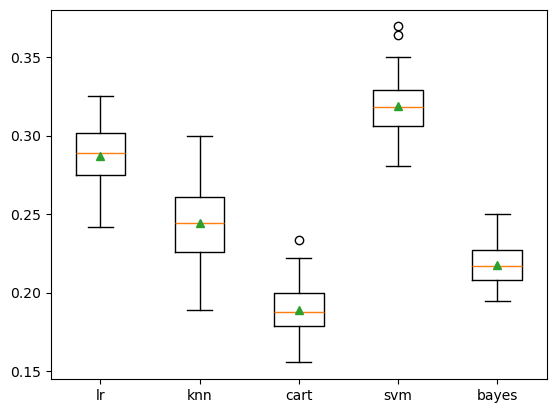

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.295 (0.020)
>knn 0.250 (0.016)
>cart 0.206 (0.021)
>svm 0.328 (0.021)
>bayes 0.184 (0.023)


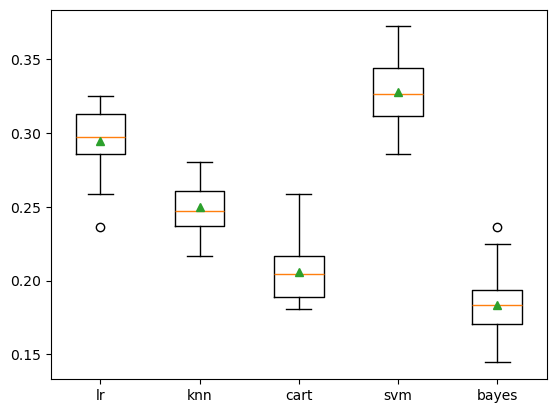

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.324 (0.022)
>knn 0.275 (0.024)
>cart 0.221 (0.018)
>svm 0.364 (0.018)
>bayes 0.212 (0.021)


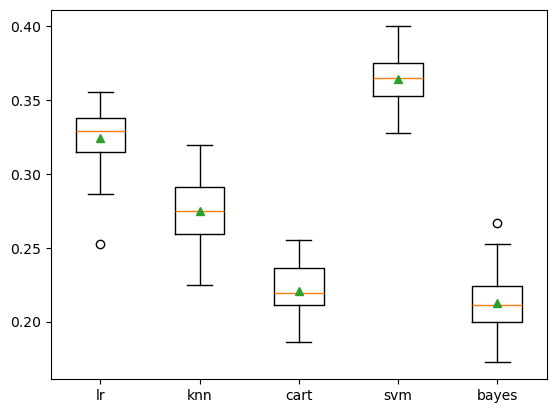

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.490 (0.028)
>knn 0.472 (0.022)
>cart 0.336 (0.025)
>svm 0.554 (0.021)
>bayes 0.406 (0.023)


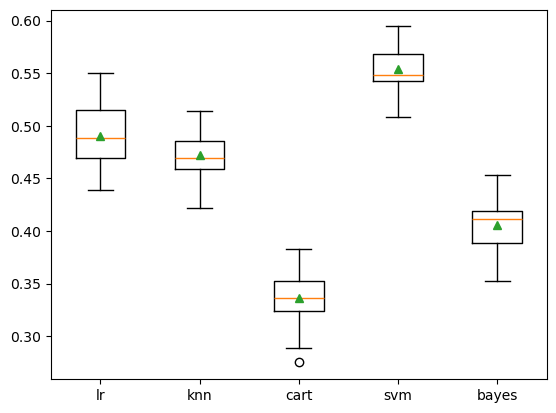

>lr 0.262 (0.013)
>knn 0.217 (0.019)
>cart 0.220 (0.021)
>svm 0.274 (0.018)
>bayes 0.232 (0.022)


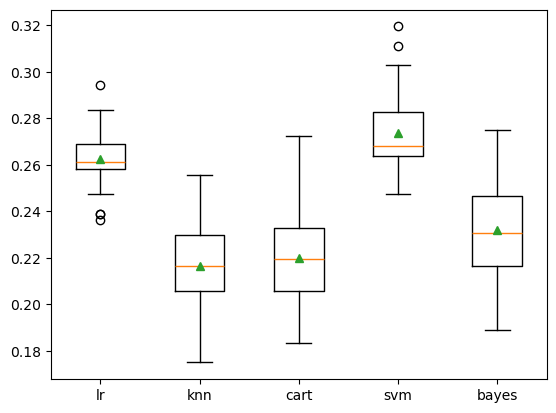

>lr 0.310 (0.019)
>knn 0.275 (0.024)
>cart 0.233 (0.019)
>svm 0.325 (0.021)
>bayes 0.279 (0.021)


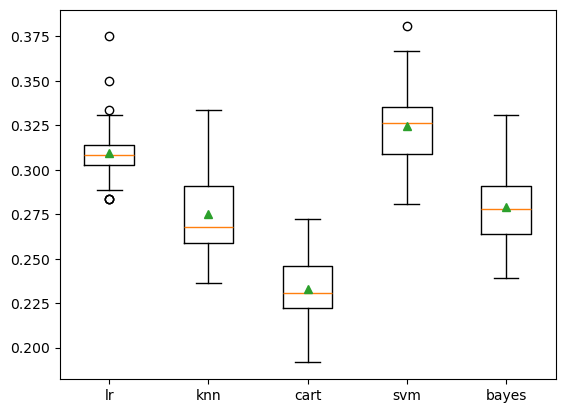

>lr 0.302 (0.021)
>knn 0.290 (0.021)
>cart 0.251 (0.025)
>svm 0.352 (0.022)
>bayes 0.297 (0.019)


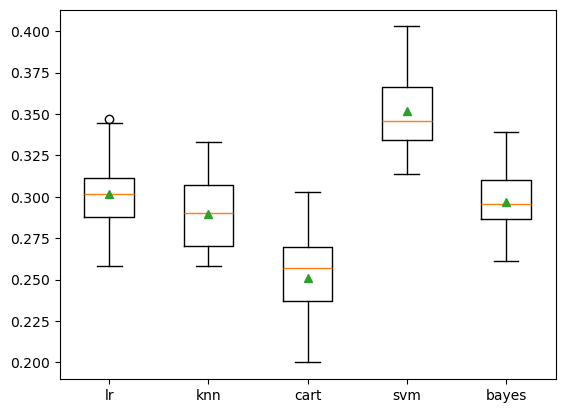

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.440 (0.025)
>knn 0.395 (0.025)
>cart 0.306 (0.023)
>svm 0.482 (0.020)
>bayes 0.372 (0.021)


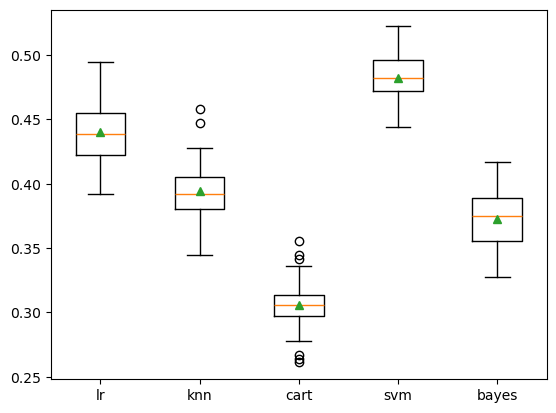

>lr 0.295 (0.019)
>knn 0.283 (0.019)
>cart 0.240 (0.023)
>svm 0.338 (0.020)
>bayes 0.273 (0.019)


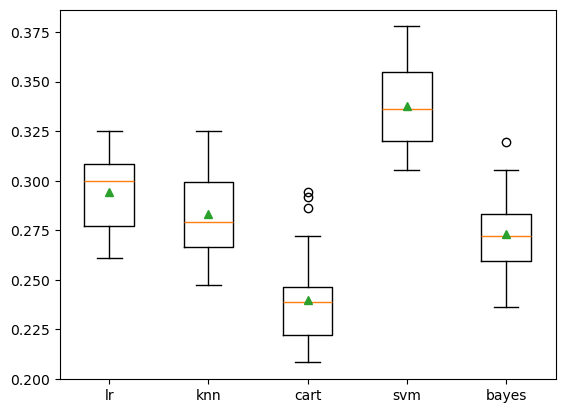

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.279 (0.022)
>knn 0.261 (0.023)
>cart 0.202 (0.021)
>svm 0.324 (0.022)
>bayes 0.256 (0.017)


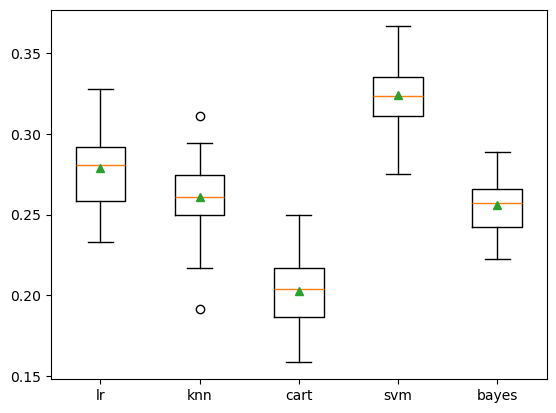

>lr 0.301 (0.020)
>knn 0.277 (0.021)
>cart 0.244 (0.021)
>svm 0.330 (0.025)
>bayes 0.275 (0.018)


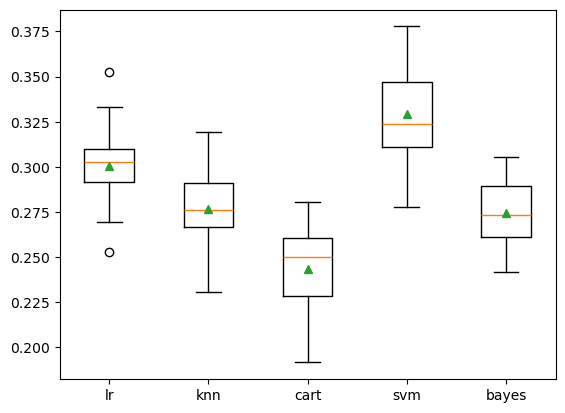

In [7]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

def get_models():
 models = dict()
 models['lr'] = LogisticRegression()
 models['knn'] = KNeighborsClassifier()
 models['cart'] = DecisionTreeClassifier()
 models['svm'] = SVC()
 models['bayes'] = GaussianNB()
 return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores
models = get_models()

y = Y_train

for cluster in train_subsets.keys():
    X = train_subsets[cluster]
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    # plot model performance for comparison
    pyplot.boxplot(results, labels=names, showmeans=True)
    pyplot.show()

### Based on hierarchical clustering

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.498 (0.024)
>knn 0.427 (0.023)
>cart 0.321 (0.023)
>svm 0.543 (0.018)
>bayes 0.394 (0.025)


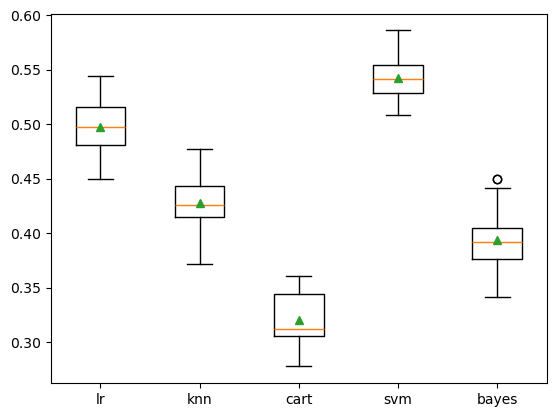

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.498 (0.024)
>knn 0.427 (0.023)
>cart 0.324 (0.023)
>svm 0.543 (0.018)
>bayes 0.394 (0.025)


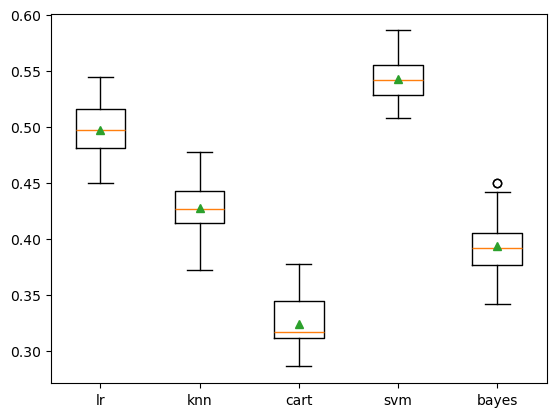

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.498 (0.024)
>knn 0.427 (0.023)
>cart 0.326 (0.024)
>svm 0.543 (0.018)
>bayes 0.394 (0.025)


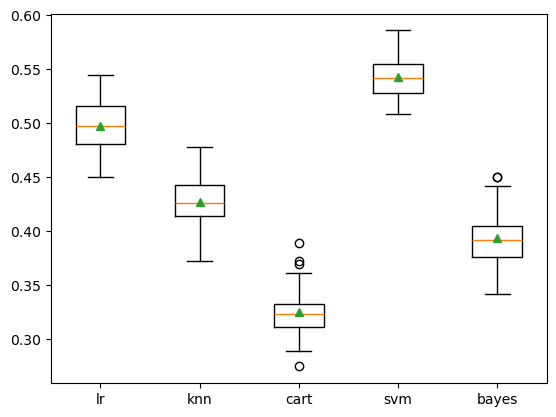

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.498 (0.024)
>knn 0.427 (0.023)
>cart 0.325 (0.021)
>svm 0.543 (0.018)
>bayes 0.394 (0.025)


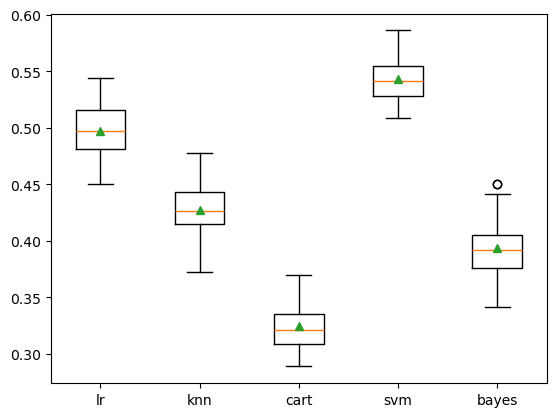

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.498 (0.024)
>knn 0.427 (0.023)
>cart 0.322 (0.025)
>svm 0.543 (0.018)
>bayes 0.394 (0.025)


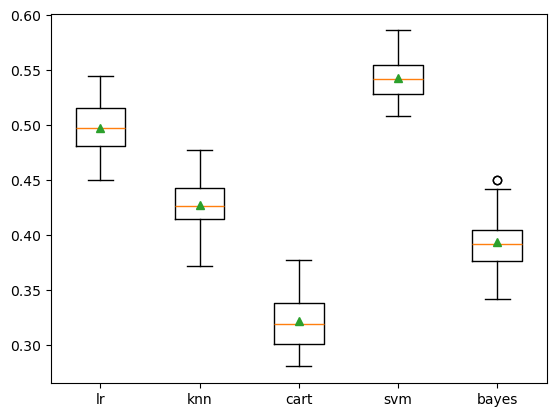

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.498 (0.024)
>knn 0.427 (0.023)
>cart 0.326 (0.025)
>svm 0.543 (0.018)
>bayes 0.394 (0.025)


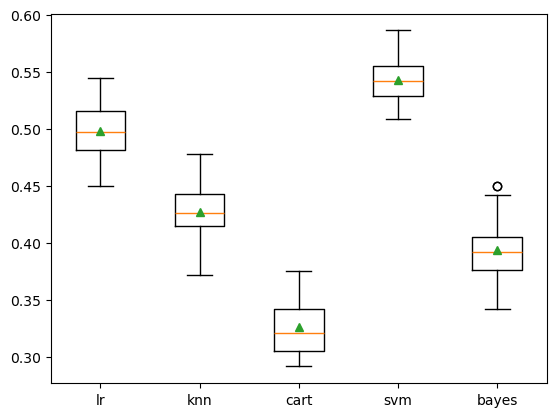

In [13]:
# Try 6 hierarchical clusters
train_subsets = split_features_by_clusters(X_train_scaled, dendrogram_label_6_clust)
val_subsets = split_features_by_clusters(X_val_scaled, dendrogram_label_6_clust)
test_subsets = split_features_by_clusters(X_test_scaled, dendrogram_label_6_clust)

for cluster in train_subsets.keys():
    X = train_subsets[cluster]
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    # plot model performance for comparison
    pyplot.boxplot(results, labels=names, showmeans=True)
    pyplot.show()

# # 10 hierarchical clusters
# train_subsets = split_features_by_clusters(X_train_scaled, dendrogram_label_10_clust)
# val_subsets = split_features_by_clusters(X_val_scaled, dendrogram_label_10_clust)
# test_subsets = split_features_by_clusters(X_test_scaled, dendrogram_label_10_clust)

### Compare the models but without splitting

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

>lr 0.489 (0.024)
>knn 0.443 (0.026)
>cart 0.339 (0.018)
>svm 0.583 (0.027)
>bayes 0.324 (0.025)


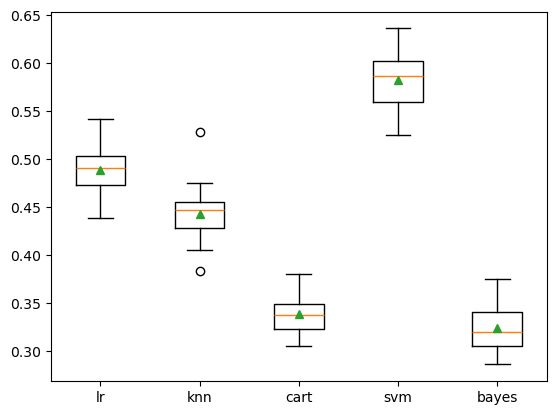

In [15]:
X, y = X_train_scaled, Y_train
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Honestly, it seems like not splitting has better performance. However, the hierarchical clusters that I obtained performed better than splitting based on the name of the features.

In [13]:
def objective(trial, X_sub, Y_sub):
    # Hyperparameters
    params = {
        'objective': 'multi:softmax',
        'num_class': 8,
        'max_depth': trial.suggest_int('max_depth', 3, 60),
        'eta': trial.suggest_float('eta', 0.01, 0.4),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'eval_metric': 'merror'  # Multiclass Classification Error
    }

    # Convert the subset dataset into DMatrix form
    dmatrix = xgb.DMatrix(X_sub, label=Y_sub)

    # Perform cross-validation
    cv_results = xgb.cv(params, dmatrix, num_boost_round=5000, nfold=5, stratified=True,
                        early_stopping_rounds=25, seed=42, verbose_eval=False)

    # Extract the minimum mean merror from the CV results
    min_mean_merror = cv_results['test-merror-mean'].min()

    return min_mean_merror

In [14]:
best_params_subsets = {}
validation_accuracies = {}

for feature_name, feature_count in feature_structure.items():
    print(f"Running study for feature subset: {feature_name}")
    
    # Prepare the data for this subset
    X_sub_train = train_subsets[feature_name]
    Y_sub_train = Y_train  # Y_train should be defined in your context

    def subset_objective(trial):
        return objective(trial, X_sub_train, Y_sub_train)

    study = optuna.create_study(direction='minimize', study_name=f"XGB_{feature_name}")
    study.optimize(subset_objective, n_trials=100)

    best_params_subsets[feature_name] = study.best_trial.params

    # # Merge train and validation subsets for final model retraining
    # X_sub_train_val_combined = np.vstack((X_sub_train, val_subsets[feature_name]))
    # Y_train_val_combined = np.concatenate((Y_train, Y_val))  # Assuming Y_val is defined
    # 
    # # Retrain the model on the combined training and validation set with the best parameters
    # dtrain_val_combined = xgb.DMatrix(X_sub_train_val_combined, label=Y_train_val_combined)
    # Retrain model with optimal parameters with more boosting rounds
    params = {
        'objective': 'multi:softmax',
        'num_class': 8,
        **best_params_subsets[feature_name],  # Unpack the best parameters
    }
    final_model = xgb.train(params, X_sub_train, num_boost_round=10_000) # dtrain_val_combined

    # Evaluate the final model on the validation set
    dval = xgb.DMatrix(val_subsets[feature_name], label=Y_val)
    preds = final_model.predict(dval)
    val_accuracy = accuracy_score(Y_val, preds)
    validation_accuracies[feature_name] = val_accuracy

    # Save the final model
    model_name = f'Models/XGBoost-Feature-Subsets/xgboost_{feature_name}_final.model'
    final_model.save_model(model_name)

    print(f"Validation accuracy for {feature_name}: {val_accuracy}")
    
## Save Results
# Format the current date and time as a string
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Filenames with date and time
filename_best_params = f"best_params_subsets_{timestamp}.json"
filename_validation_accuracies = f"validation_accuracies_{timestamp}.json"

# Save best_params_subsets
with open(filename_best_params, 'w') as file:
    json.dump(best_params_subsets, file, indent=4)

# Save validation_accuracies
with open(filename_validation_accuracies, 'w') as file:
    json.dump(validation_accuracies, file, indent=4)

[I 2024-03-13 21:37:41,632] A new study created in memory with name: XGB_chroma_cens


Running study for feature subset: chroma_cens


[W 2024-03-13 21:37:52,060] Trial 0 failed with parameters: {'max_depth': 23, 'eta': 0.3402870179530016, 'subsample': 0.9958749063412999, 'colsample_bytree': 0.6580204997995794} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/lq/x2t80c813gsbg58jgjy302hc0000gn/T/ipykernel_66699/2400233774.py", line 12, in subset_objective
    return objective(trial, X_sub_train, Y_sub_train)
  File "/var/folders/lq/x2t80c813gsbg58jgjy302hc0000gn/T/ipykernel_66699/2428057373.py", line 17, in objective
    cv_results = xgb.cv(params, dmatrix, num_boost_round=5000, nfold=5, stratified=True,
  File "/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/xgboost/training.py", line 538, in cv
    booster.update(i, obj)
  File "/opt/homebrew/anaconda3/envs/sml-pr

KeyboardInterrupt: 

## Save Best Parameters 

In [ ]:
# import json
# from datetime import datetime
# # Format the current date and time as a string
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# 
# # Filenames with date and time
# filename_best_params = f"best_params_subsets_{timestamp}.json"
# filename_validation_accuracies = f"validation_accuracies_{timestamp}.json"
# 
# # Save best_params_subsets
# with open(filename_best_params, 'w') as file:
#     json.dump(best_params_subsets, file, indent=4)
# 
# # Save validation_accuracies
# with open(filename_validation_accuracies, 'w') as file:
#     json.dump(validation_accuracies, file, indent=4)
